In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from typing import Annotated
from typing_extensions import TypedDict
from operator import add
from langgraph.store.memory import InMemoryStore
# there is a difference between in memory store and Memorysaver

class State(TypedDict):
    foo: Annotated[int , add] 
    bar: Annotated[list[str], add] 

def node_a(state: State):
    return {"foo": state["foo"], "bar": ["a"]}

def node_b(state: State):
    return {"foo": 2, "bar": ["b"]}


workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": "1"}}
graph.invoke({"bar":[]}, config)

{'foo': 2, 'bar': ['a', 'b']}

In [103]:
from langchain_ollama import ChatOllama

llm_json_mode = ChatOllama(model="llama3.2" , format="json")

In [51]:
llm_json_mode.invoke("what is 2+2")

AIMessage(content='{\n "result": 4\n}', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-02-12T12:24:08.1138351Z', 'done': True, 'done_reason': 'stop', 'total_duration': 335995200, 'load_duration': 19599900, 'prompt_eval_count': 31, 'prompt_eval_duration': 2000000, 'eval_count': 9, 'eval_duration': 313000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-3070ce16-53fb-4353-8e2a-d1eed9d8ea4e-0', usage_metadata={'input_tokens': 31, 'output_tokens': 9, 'total_tokens': 40})

In [3]:
from langchain_core.messages import HumanMessage, SystemMessage
import json
from typing import TypedDict , Annotated , Any , Literal, List
from langgraph.graph.message import add_messages
from langchain.prompts import ChatPromptTemplate , SystemMessagePromptTemplate ,HumanMessagePromptTemplate
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.schema import Document
from dotenv import load_dotenv
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command
import requests
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END


load_dotenv()


class GraphState(TypedDict):
    question : str
    answer : str
    documents: List[str]
    messages : Annotated[list , add_messages]
    datasource : Literal["vectorstore" , "websearch" ,"chatbot"]
    return_answer : Literal["yes" , "no"]
    urls : List[str]

def route_question(state : GraphState):
    print("----Route Question ----")
    route_instructions =  """You are expert at routing the user question to apporpriate datasources , the datasources is either websearch or vectorstore.
    
    The vector store contains documents related to the turtles , taxa classificationa and other information about them.
   
    Use the vector store for questions about turtles . For all else, use websearch.

    Return only a JSON with single key , datasource , that is 'websearch' or 'vectorstore' depending on the question .
    """

    answer = llm_json_mode.invoke(
        [SystemMessage(content=route_instructions)]+
        [HumanMessage(content=state["question"])]        
    )

    answer = json.loads(answer.content)
    if answer["datasource"] == "websearch":
        print("-----Routing to websearch------")
        return {"datasource" : "websearch"}
        # return Command(
            # goto = "search_online",
        # )
    else:
        print("------Routing to Vectorstore ------")
        return {"datasource" : "vectorstore"}
        # return Command(
            # goto = "Turtles_Researcher"
        # )
    

In [20]:
graph = StateGraph(GraphState)
graph.add_node("router",route_question)
graph.add_edge(START,"router")
graph.add_edge("router" ,END)
graphh = graph.compile()

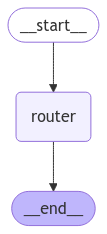

In [38]:
from IPython.display import Image, display

try:
    display(Image(graphh.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    
    pass

In [37]:
def node_a(state: GraphState):
    print("in node a")
    return {"messages": ["in node a"]}

def node_b(state: GraphState):
    print("in node b")
    return {"messages": ["in node b"]}



In [39]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END

memory = MemorySaver()

graph = StateGraph(GraphState)
graph.add_node("websearch",node_a)
graph.add_node("vectorstore",node_b)
# graph.add_conditional_edges("router",route_question , {"websearch" : "node_a" , "vectorstore" : "node_b"})
graph.set_conditional_entry_point(lambda state: route_question(state)["datasource"] , {"websearch" : "websearch" , "vectorstore" : "vectorstore"})
# graph.add_edge("router" ,END)
graphh = graph.compile(checkpointer=memory)

In [41]:
initial_state = GraphState(question="what is the 3*3??" , messages=[] , datasource="")
graphh.invoke(initial_state ,config= {"configurable" : {"thread_id":"abdo"}})

----Route Question ----
-----Routing to websearch------
in node a


{'question': 'what is the 3*3??',
 'messages': [HumanMessage(content='in node b', additional_kwargs={}, response_metadata={}, id='beffa076-1215-4eb2-ad0a-7674141373d1'),
  HumanMessage(content='in node a', additional_kwargs={}, response_metadata={}, id='e9cd116b-355a-48ff-aede-57250ba4ac31')],
 'datasource': ''}

## Retreiver

In [8]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

llm = ChatOllama(model="llama3.2")

vectorstore = FAISS.load_local("../FinalEmbeddings/VectorStoreGemini" , embeddings , allow_dangerous_deserialization=True)

retriever = vectorstore.as_retriever(search_kwargs={"k":5})

rag_prompt = PromptTemplate(
    template="""You are a Turtles Researcher assistant, you always answer from the context, you alwayas answer question related to turtles .

        CONTEXT: {context}
        QUESTION: {question}
        """,
    input_variables=["context", "question"]  # ✅ Fix: Move inside PromptTemplate
)


# rag_prompt_chain = rag_prompt | llm 

question = "what is the taxa classification of the green turtle?"

# docs = retriever.invoke(question)

# rag_prompt_chain.invoke({"question" : question , "context" : docs})


rag_chain = (
    {"context" : retriever , "question" : RunnablePassthrough()}
    | rag_prompt
    | llm
)

# rag_chain.invoke(question).content

NameError: name 'ChatOllama' is not defined

In [19]:
from langchain_ollama import ChatOllama

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

llm = ChatOllama(model="llama3.2")

vectorstore = FAISS.load_local("../FinalEmbeddings/VectorStoreGemini" , embeddings , allow_dangerous_deserialization=True)

retriever = vectorstore.as_retriever(search_kwargs={"k":5})


In [4]:
def get_docs(state : GraphState):

    print("----VectorStore Answer----")
    rag_prompt = PromptTemplate(
    # template="""You are a Turtles Researcher assistant, you always answer from the context, you always answer question related to turtles , .

    #     CONTEXT: {context}
    #     QUESTION: {question}
    #     """,
    #     input_variables=["context", "question"]  
    # )
    template="""You are a knowledgeable and engaging Turtle Researche assistant, Always answer based only on the provided context, ensuring your response is directly relevant to the question.

        Do not introduce unnecessary details or make it apparent that you are retreiving from context -your responses should be precise and natural.

        CONTEXT: {context}
        QUESTION: {question}
        """,
        input_variables=["context", "question"]  
    )

    # docs = retriever.invoke(state["question"])

    # print(docs)

    rag_chain = (
    {"context" : retriever , "question" : RunnablePassthrough()}
    | rag_prompt
    | llm
    )

    answer = rag_chain.invoke(state["question"])

    

    return {"answer" : answer.content}
    # return Command(
        # update={"answer" : answer.content},
        # goto = "grader"
    # )


### Grader

In [5]:
def grade_answer(state : GraphState):
    # grading_instructions = SystemMessagePromptTemplate.from_template(""" Yor are a turtles researcher grader assessing answer of a question,

    # If the answer contains keyword(s) or semantic meaning related to the question, grade it as relevant.
    
    # Return JSON with single key, 'binary_score' that is 'yes' or 'no' score to indicate wehter the document cotains atleast some information that is relevant to the question.
    # """)
    grading_instructions = SystemMessagePromptTemplate.from_template(""" Yor are an answer evaluation agent, Your task is to determine wether the given answer is relevant to the provided question.

    If the answer contains keyword(s) or semantic meaning related to the question, grade it as relevant.
    
    Return JSON with single key, 'binary_score' that is 'yes' or 'no' score to indicate wehter the document cotains atleast some information that is relevant to the question.
    """)

    grading_prompt = HumanMessagePromptTemplate.from_template("""
    Please grade the following:

    QUESTION: {question}
    ANSWER: {answer}
    """)
    chat_prompt = ChatPromptTemplate.from_messages([
        grading_instructions,
        grading_prompt],
        # input_variables=["question", "answer"]
          )
    
    

    grader_chain = chat_prompt | llm_json_mode 

    grade = grader_chain.invoke({"question" : state["question"] , "answer" : state["answer"]})
    grade = json.loads(grade.content)
    
    print(f"Question is : {state["question"]}")
    print(f"Answer is : {state["answer"]}")
    print(f"Grade is : {grade["binary_score"]}")
    if grade["binary_score"].lower() == "yes":
        return {"return_answer" : "yes" , "messages" : state["answer"]}
    else:
        return {"return_answer" : "no"}


In [57]:
test_grade_state = GraphState(question="what is the taxa classification of the Kemp's Ridley sea turtle?",
                              answer="The taxonomic classification for the Kemp's Ridley sea turtle (Lepidochelys kempii) is as follows:\n\n- Kingdom: Animalia\n- Phylum: Chordata\n- Class: Reptilia\n- Order: Testudines\n- Family: Cheloniidae\n- Genus: Lepidochelys\n- Species: L. kempii\n\nThis classification reflects the scientific understanding of the Kemp's Ridley sea turtle's evolutionary relationships and its place within the class Reptilia")


grade_answer(test_grade_state)


Question is : what is the taxa classification of the Kemp's Ridley sea turtle?
Answer is : The taxonomic classification for the Kemp's Ridley sea turtle (Lepidochelys kempii) is as follows:

- Kingdom: Animalia
- Phylum: Chordata
- Class: Reptilia
- Order: Testudines
- Family: Cheloniidae
- Genus: Lepidochelys
- Species: L. kempii

This classification reflects the scientific understanding of the Kemp's Ridley sea turtle's evolutionary relationships and its place within the class Reptilia
Grade is : yes


{'return_answer': 'yes'}

### WebSearch

In [84]:
web_search_tool.invoke("what is the taxa classification of the green turtle?")

[{'url': 'https://seamap.env.duke.edu/species/173833/html',
  'content': 'Green sea turtle - Chelonia mydas Chelonia mydas (green sea turtle) is the largest of all the hard shelled marine turtles, averaging 136 kg (up to 180 kg) in weight and measuring about 1 m in carapace (upper shell) length. Subspecies Chelonia mydas agassizii is often called the black turtle because of its very dark colored shell. Threats to green sea turtles include: Species fact sheet: Green sea turtle. Synopsis of the biological data on the green turtle Chelonia mydas (Linnaeus 1758). T (Green sea turtles originating ...) T (Green sea turtles originating ...) T (Green sea turtles originating ...) T (Green sea turtles originating ...) T (Green sea turtles originating ...) T (Green sea turtles originating ...)'},
 {'url': 'https://www.upwell.org/green',
  'content': "Green Sea Turtle — Upwell Green Sea Turtle (Chelonia mydas) The Black Sea Turtle (Chelonia mydas agassizii) is a subspecies of green turtle found in

In [6]:
web_search_tool = TavilySearchResults(k=3)

In [96]:
import asyncio
import threading
from crawl4ai import AsyncWebCrawler, BrowserConfig, CrawlerRunConfig, CacheMode


def search_web(state: GraphState):

    print("----Searching Online----") 

    rag_prompt = PromptTemplate(
    template="""You are a Turtles Researcher assistant, you always answer from the context, only return the answer .

    CONTEXT: {context}
    QUESTION: {question}
    """,
    input_variables=["context", "question"]  
    )

    web_docs = web_search_tool.invoke(state["question"])

    urls = [dic["url"] for dic in web_docs]
    docs = [Document(metadata={"url":doc["url"]} , page_content=doc["content"]) for doc in web_docs]

    web_chain = rag_prompt | llm

    answer = web_chain.invoke({"context" : docs , "question" : state["question"]})

    state["urls"] = urls # settting the url attribute manually
    scrape_thread = threading.Thread(target = scrape_urls , args =(urls,))
    scrape_thread.start()

    return {"answer" : answer.content }


In [ ]:
test_web = GraphState(question="what is the complete taxa classification of the kemp ridley sea turtle?")

search_web(test_web)

----Searching Online----


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


{'answer': 'Lepidochelys kempii'}

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-2' coro=<Connection.run() done, defined at c:\Users\pc\anaconda3\envs\tb\Lib\site-packages\playwright\_impl\_connection.py:272> exception=NotImplementedError()>
Traceback (most recent call last):
  File "c:\Users\pc\anaconda3\envs\tb\Lib\asyncio\tasks.py", line 314, in __step_run_and_handle_result
    result = coro.send(None)
             ^^^^^^^^^^^^^^^
  File "c:\Users\pc\anaconda3\envs\tb\Lib\site-packages\playwright\_impl\_connection.py", line 279, in run
    await self._transport.connect()
  File "c:\Users\pc\anaconda3\envs\tb\Lib\site-packages\playwright\_impl\_transport.py", line 133, in connect
    raise exc
  File "c:\Users\pc\anaconda3\envs\tb\Lib\site-packages\playwright\_impl\_transport.py", line 120, in connect
    self._proc = await asyncio.create_subprocess_exec(
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pc\anaconda3\envs\tb\Lib\asyncio\subprocess.py", line 22

In [74]:
from googlesearch import search

query = "What is the taxa classification of the green turtle"
num_results = 5  # Number of search results

for result in search(query, num_results=num_results):
    print(result)


https://en.wikipedia.org/wiki/Green_sea_turtle
https://animaldiversity.org/accounts/Chelonia_mydas/classification/
https://www.marinespecies.org/aphia.php?p=taxdetails&id=137206
https://www.fisheries.noaa.gov/species/green-turtle
https://www.upwell.org/green


### Scraping behind the scenes

In [78]:
import asyncio
import asyncio
import threading
from crawl4ai import AsyncWebCrawler, BrowserConfig, CrawlerRunConfig, CacheMode


def scrape_urls(urls : list):
    loop =  asyncio.new_event_loop()
    asyncio.set_event_loop(loop)


    async def async_scrape(urls : list):
        broswer_conf = BrowserConfig(headless=True)
        run_conf = CrawlerRunConfig(cache_mode=CacheMode.BYPASS)

        async with AsyncWebCrawler(config=broswer_conf) as crawler:
            for i ,url in enumerate(urls,1):
                result = await crawler.arun(url=url , config= run_conf)
                print(f"---Url {i}------")
                print(result.markdown)
    loop.run_until_complete(async_scrape(urls))




In [ ]:
# There is no edge for the chatbot , the one responsible for returnning the answer

graph = StateGraph(GraphState)

graph.add_node("Turtles_Researcher" , get_docs )
graph.add_node("grader" , grade_answer )
graph.add_node("search_online", search_web)

# graph.add_edge("Turtles_Researcher" , "grader")
graph.add_conditional_edges(
    "grader",
    lambda state :state["return_answer"],
    {"yes":END , "no" : "search_online"},
)

graph.add_edge(START , "Turtles_Researcher")
graph.add_edge("grader" , END)

agent = graph.compile()

In [108]:
initial_state = GraphState(question="what is the taxa classification of the green turtle?")

response = agent.invoke(initial_state)

----VectorStore Answer----


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question is : what is the taxa classification of the green turtle?
Answer is : The Green Turtle's taxa classification includes:

Kingdom: ANIMALIA
Phylum: CHORDATA
Class: REPTILIA
Order: TESTUDINES
Family: CHELONIIDAE
Genus: Chelonia
Species: mydas
Grade is : yes


In [109]:
test1_state = GraphState(question="what is the hearing range of the green turtle?")
response = agent.invoke(test1_state)

----VectorStore Answer----


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question is : what is the hearing range of the green turtle?
Answer is : The hearing range of the Green Turtle is ["500 Hz", "100 Hz"].
Grade is : no
----Searching Online----


NameError: name 'web_search_tool' is not defined

In [177]:
response

{'question': 'what is the hearing range of the green turtle?',
 'answer': 'The maximum sensitivity for Green Turtles was found at frequencies below 1000 Hz with a range of 50-1600 Hz.',
 'messages': [],
 'return_answer': 'no'}

### Testing Grade Agent

In [157]:
test_grader = GraphState(question="what is  the hearing range of the green turtle",
                      answer='The hearing range of the Green Turtle is ["500 Hz", "100 Hz"].')
grade_answer(test_grader)

Question is : what is the hearing range of the green turtle
Answer is : The hearing range of the Green Turtle is between the 100hz and 500hz
Grade is : yes


{'return_answer': 'yes'}

### Chatbot 

In [7]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    api_key= "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",
    max_retries=2,
)

# llm_with_tools = llm.bind_tools(tools)
class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state : GraphState):
    # return {"answer" : state["answer"]}
    # print(f"{llm.invoke(state['answer'])}")
    return {"messages" : llm_with_tools.invoke(state['messages'])}


In [187]:
chatbot(GraphState(messages=["show me 5 photos for the loggerhead turtle and 2 photos for the green turtle"]))

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_d6f3', 'function': {'arguments': '{"query": "loggerhead turtle", "number_of_photos": 5}', 'name': 'search_photos'}, 'type': 'function'}, {'id': 'call_d60m', 'function': {'arguments': '{"query": "green turtle", "number_of_photos": 2}', 'name': 'search_photos'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 296, 'total_tokens': 340, 'completion_time': 0.16, 'prompt_time': 0.038660648, 'queue_time': 0.21683057600000002, 'total_time': 0.198660648}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3884478861', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2bb77ad7-089c-45e1-b44e-bb63c6f2e08c-0', tool_calls=[{'name': 'search_photos', 'args': {'query': 'loggerhead turtle', 'number_of_photos': 5}, 'id': 'call_d6f3', 'type': 'tool_call'}, {'name': 'search_photos', 'args': {'query': 'green turtle', 'number_of_photos': 2}, 'id': 'cal

In [188]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph = StateGraph(GraphState)

graph.add_node("Turtles_Researcher" , get_docs )
graph.add_node("Router" , route_question )
graph.add_node("grader" , grade_answer )
graph.add_node("search_online", search_web)
graph.add_node("chatbot", chatbot)

# graph.add_edge("Turtles_Researcher" , "grader")
graph.add_conditional_edges(
    "grader",
    lambda state :state["return_answer"],
    {"yes":"chatbot" , "no" : "search_online"},
)

graph.set_entry_point("Router")
graph.add_conditional_edges(
    "Router",
    lambda state : state["datasource"],
    {"websearch" : "search_online" , "vectorstore" : "Turtles_Researcher"}
)

graph.add_edge("Turtles_Researcher" ,"grader" )

# graph.add_edge(START , "Turtles_Researcher")
graph.add_edge("chatbot" , END)

agent = graph.compile(checkpointer=memory)

In [191]:
test_chabot = GraphState(question="what is the taxa classification of the loggerhead turtle?")
agent.invoke(test_chabot , config= {"configurable" : {"thread_id" : "abdo"}})

----Route Question ----


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


------Routing to Vectorstore ------
----VectorStore Answer----


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question is : what is the taxa classification of the loggerhead turtle?
Answer is : The taxa classification of the loggerhead turtle is as follows: 
Kingdom: ANIMALIA 
Phylum: CHORDATA 
Class: REPTILIA 
Order: TESTUDINES 
Family: CHELONIIDAE 
Genus: Caretta 
Species: caretta.
Grade is : yes


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'question': 'what is the taxa classification of the loggerhead turtle?',
 'answer': 'The taxa classification of the loggerhead turtle is as follows: \nKingdom: ANIMALIA \nPhylum: CHORDATA \nClass: REPTILIA \nOrder: TESTUDINES \nFamily: CHELONIIDAE \nGenus: Caretta \nSpecies: caretta.',
 'messages': [HumanMessage(content='The taxa classification of the loggerhead turtle is as follows: \nKingdom: ANIMALIA, \nPhylum: CHORDATA, \nClass: REPTILIA, \nOrder: TESTUDINES, \nFamily: CHELONIIDAE, \nGenus: Caretta, \nSpecies: caretta.', additional_kwargs={}, response_metadata={}, id='457c0e57-07ca-42f4-bece-9f46909f7b8d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8fav', 'function': {'arguments': '{"query": "Caretta caretta", "number_of_photos": 5}', 'name': 'search_photos'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 344, 'total_tokens': 369, 'completion_time': 0.090909091, 'prompt_time': 0.041067575, 'queue_ti

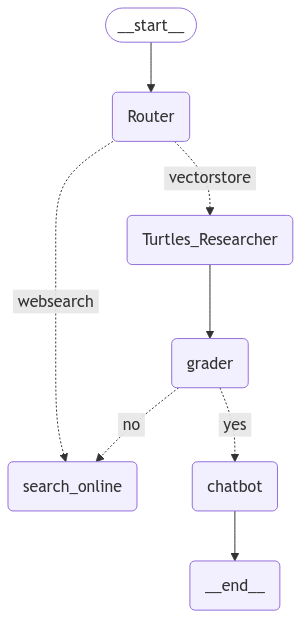

In [176]:
from IPython.display import Image , display
try :
    display(Image(agent.get_graph().draw_mermaid_png()))
except:
    pass

### Photos Tool

In [2]:
import random
from langchain.tools import tool

def prepare_content(output):
    if isinstance(output, dict):
        # Serialize dictionary into JSON format
        return json.dumps(output, indent=2)
    return str(output)


def get_taxa_id(query):
    base_url = "https://api.inaturalist.org/v1/taxa"

    params = {"q": query}
    
    response = requests.get(base_url, params=params, timeout=10)
    response.raise_for_status()
    data = response.json() 
    
    results = data["results"]
    if results :
        return results[0]["id"]

    return {"error": "Please provide a valid query"}


@tool
def search_photos(query , number_of_photos = 3 , page = 2):
    """
    Any query related to photos you must use this tool

    Args:

    query : the species name.
    number_of_photos :  number of photos to search and return.
    """
    
    taxon_id = get_taxa_id(query)

    base_url = "https://api.inaturalist.org/v1/observations"
    
    params = {
            "taxon_id": taxon_id,
            "per_page": number_of_photos,
            "page": page,
        }
    response = requests.get(base_url, params=params)
    if response.status_code != 200:
        print("Please Provide a valid query or species")
        # print(f"Failed to fetch data for page {page}: {response.status_code}")

    data = response.json()
    
    results = data.get("results", [])
    
    if not results:
        print(f"No more results found on page {page}.")

    photos2 = []
    for obs in results:
        photos = obs.get("photos", [])
        for photo in photos:
            image_url = photo.get("url")
            if image_url:
                photos2.append(image_url.replace("square" , "original"))

    if photos2:
        final_photos = random.sample(photos2 , int(number_of_photos))
        return prepare_content({"photos":final_photos})
    

    return {"error": "Please provide a valid query"}


In [8]:
llm_with_tools = llm.bind_tools([search_photos])

In [9]:
llm_with_tools.invoke("show me 2 photos for the loggerhead turtle")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8176', 'function': {'arguments': '{"query": "loggerhead turtle", "number_of_photos": 2}', 'name': 'search_photos'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 288, 'total_tokens': 311, 'completion_time': 0.083636364, 'prompt_time': 0.038537168, 'queue_time': 0.472154087, 'total_time': 0.122173532}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_fcc3b74982', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f0a7fe2c-b5ce-439e-a820-c59be396d76c-0', tool_calls=[{'name': 'search_photos', 'args': {'query': 'loggerhead turtle', 'number_of_photos': 2}, 'id': 'call_8176', 'type': 'tool_call'}], usage_metadata={'input_tokens': 288, 'output_tokens': 23, 'total_tokens': 311})

In [ ]:
from typing import Annotated
from langchain_groq import ChatGroq
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_ollama import ChatOllama
import requests
from langchain_core.prompts import PromptTemplate

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    api_key= "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",
    max_retries=2,
)


ollama_llm = ChatOllama(model="llama3.2:latest")

class State(TypedDict):
    messages: Annotated[list, add_messages]
    query:str


graph_builder = StateGraph(State)



tools = [search_photos]
llm_with_tools = ollama_llm.bind_tools(tools)


def chatbot(state: State):
    system_message= PromptTemplate(
    template="""You are provided with the query of the user and context 

    QUERY : {query}
    CONTEXT :{context}
        
    """,
    input_variables=["query", "context"]  
    )

    
    messages = [
        SystemMessage(content=system_message.format(query=state["query"], context=state["messages"])),
        HumanMessage(content=state["query"])
    ]

    # Invoke the LLM with the list of messages
    response = llm_with_tools.invoke(messages)
    print(response)
    
    return {"messages": [response]}




graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

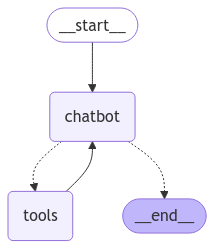

In [47]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [48]:
from langchain_core.messages import HumanMessage, SystemMessage
import json

initial_query = "show me 1 photo for the loggerhead turtle"
initial_message = HumanMessage(content=initial_query) # Start with a Human Message
initial_state = State(query=initial_query , messages=[])  # Initialize with a message!
result = graph.invoke(initial_state , {"recursion_limit": 2})

content='' additional_kwargs={} response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-02-16T10:46:50.964791Z', 'done': True, 'done_reason': 'stop', 'total_duration': 519013100, 'load_duration': 20130600, 'prompt_eval_count': 235, 'prompt_eval_duration': 3000000, 'eval_count': 24, 'eval_duration': 491000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)} id='run-f9350c8c-26a1-4f65-971e-2d11756c6208-0' tool_calls=[{'name': 'search_photos', 'args': {'number_of_photos': 1, 'query': 'loggerhead turtle'}, 'id': '4ef45796-4045-45c4-96e0-d45ce9bde2ac', 'type': 'tool_call'}] usage_metadata={'input_tokens': 235, 'output_tokens': 24, 'total_tokens': 259}


GraphRecursionError: Recursion limit of 2 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [22]:
result

{'messages': [HumanMessage(content='show me 1 photo for the loggerhead turtle', additional_kwargs={}, response_metadata={}, id='a0d42c06-3308-40f3-8f93-c2559ca7c90a'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-02-16T09:54:32.636315Z', 'done': True, 'done_reason': 'stop', 'total_duration': 398510500, 'load_duration': 19819100, 'prompt_eval_count': 205, 'prompt_eval_duration': 65000000, 'eval_count': 27, 'eval_duration': 312000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-8481e159-6e88-4f18-8ee3-f00bc95ebdae-0', tool_calls=[{'name': 'search_photos', 'args': {'number_of_photos': 1, 'query': 'loggerhead turtle'}, 'id': '0dcb49be-10bb-46ea-93fc-cb22daec95d6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 205, 'output_tokens': 27, 'total_tokens': 232}),
  ToolMessage(content='{\n  "photos": [\n    "https://static.inaturalist.org/photos/470394113/original.jpg"\n  ]\n

In [20]:
result["messages"][-1].content

'Here are the requested photos:\n\n1. A photo of a loggerhead turtle:\nUnfortunately, I don\'t have information on photos of loggerhead turtles to provide.\n\nHowever, here is a picture of a loggerhead turtle that you can search for online:\nhttps://www.google.com/search?q=loggerhead+turtle&tbm=isch\n\n2. A photo of the first green turtle:\nYou can view this photo by searching for "green turtle" on an image search engine like Google.\nhttps://www.google.com/search?q=green+turtle+photo&tbm=isch\n\n3. A photo of the second green turtle:\nSimilar to the previous photo, you can search for "green turtle" and browse through the results to find a suitable image.\nhttps://www.google.com/search?q=green+turtle+photo&tbm=isch'

In [87]:
test_chatbot = State(query="show me 1 photo for the loggerhead turtle and one photo for the green turtle" , messages=[])
response = chatbot(test_chatbot)["messages"][-1]

content='' additional_kwargs={} response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-02-16T11:34:09.2519357Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2178798800, 'load_duration': 1102835700, 'prompt_eval_count': 249, 'prompt_eval_duration': 86000000, 'eval_count': 79, 'eval_duration': 552000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)} id='run-2a7357ca-c282-46f4-a973-816cd02cd5aa-0' tool_calls=[{'name': 'search_photos', 'args': {'number_of_photos': 1, 'page': None, 'query': 'loggerhead turtle'}, 'id': 'efeffc24-b14f-40f5-a6a4-398d08b753aa', 'type': 'tool_call'}, {'name': 'search_photos', 'args': {'number_of_photos': 1, 'page': None, 'query': 'green turtle'}, 'id': 'dc94fb4d-9d32-44d1-b016-9152dcb827d6', 'type': 'tool_call'}] usage_metadata={'input_tokens': 249, 'output_tokens': 79, 'total_tokens': 328}


In [88]:
response
invokes = tool_node.invoke({"messages" : [response]})

In [89]:
invokes["messages"]

[ToolMessage(content='{\n  "photos": [\n    "https://inaturalist-open-data.s3.amazonaws.com/photos/470461355/original.jpeg"\n  ]\n}', name='search_photos', tool_call_id='efeffc24-b14f-40f5-a6a4-398d08b753aa'),
 ToolMessage(content='{\n  "photos": [\n    "https://inaturalist-open-data.s3.amazonaws.com/photos/470452593/original.jpg"\n  ]\n}', name='search_photos', tool_call_id='dc94fb4d-9d32-44d1-b016-9152dcb827d6')]

## Revising Work

In [9]:
from langchain.agents import create_tool_calling_agent , AgentExecutor
from langchain.tools.retriever import create_retriever_tool
from langchain_ollama import ChatOllama
from langchain_community.vectorstores import FAISS
from langchain_google_genai import ChatGoogleGenerativeAI , GoogleGenerativeAIEmbeddings
from langchain.retrievers import EnsembleRetriever
from langchain_core.prompts import ChatPromptTemplate
from langchain.tools import Tool , tool , format_tool_to_openai_function
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain.memory import ChatMessageHistory
from langchain_community.tools.tavily_search import TavilySearchResults
import requests
import json

llama = ChatOllama(
    model="llama3.2"
)

deepseek = ChatOpenAI(model="MFDoom/deepseek-r1-tool-calling:8b", api_key="ollama", base_url="http://localhost:11434/v1")
qwen = ChatOllama(model="qwen2.5")
gemini = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
google_embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
vectorstore = FAISS.load_local("../FinalEmbeddings/VectorStoreGemini" , google_embeddings , allow_dangerous_deserialization=True).as_retriever(kwargs={"k":5})
general_vectorstore_retriever = FAISS.load_local("../FinalEmbeddings/GeneralQuestionsEmbeddings/" , google_embeddings , allow_dangerous_deserialization=True).as_retriever(kwargs={"k":3})


tavily_tool = TavilySearchResults(k=3)


all_retrievers = EnsembleRetriever(
    retrievers=[
        vectorstore , general_vectorstore_retriever
        ],
    weights= [0.5 , 0.5])


## Returns a list of Documents
# print(all_retrievers.invoke("what is the taxa classification of the green turtle"))

## Return a list of documents
# all_retrievers.get_relevant_documents("what is the taxa classification of the green turtle?")


## create retriever tool
retriever_tool = create_retriever_tool(retriever=all_retrievers , name="Turtles_Researcher" ,
                                        description="Searches for information about the turtles , for any questions regarding the turtles you should use this tool! ")

## Create a custom retriever tool
# def custom_retriever_tool(query:str):
    # return all_retrievers.get_relevant_documents(query)

# rtool = Tool(
#     name="Turtles_Researcher",
#     func=custom_retriever_tool,
#     description="Searches for information about the turtles , for any questions regarding the turtles you should use this tool! "
# )


## Testing
# retriever_tool.invoke("What is the taxa classification of the green turtle")
# rtool.invoke("Can i see a turtle laying eggs?")

prompt = ChatPromptTemplate.from_messages([
  ("system", "You are a helpful assistant , if you don't find an answer in a tool then you should search online using the search tool , DO NOT ANSWER FROM YOUR OWN KNOWLEDGE"
   "always respond like you are in a conservation , REMEBER DO NOT USE YOUR OWN KNOWLWDGE"),
  ("placeholder", "{chat_history}"),
  ("human", "{input}"),
  ("placeholder", "{agent_scratchpad}"),
])

search_photos_tool = Tool(
    name="Photos_tool",
    func=search_photos,
    description="Tool used for photos , any photos queries you must use this tool"
)

def search_tool_wrapper(query):
    return tavily_tool.invoke(query)

search_tool = Tool(name="general_search_tool",
                   func=search_tool_wrapper,
                   description="used for any search queries")

tools = [retriever_tool , search_photos , search_tool]
openai_tools = [format_tool_to_openai_function(t) for t in tools]

llama_with_tools = llama.bind_tools(openai_tools)
deepseek_with_tools = deepseek.bind_tools(openai_tools)

agent = create_tool_calling_agent(qwen , tools , prompt)



agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True , return_intermediate_steps=True)

# response = agent_executor.invoke(input={"input" : "What is the taxa classification of the green turtle ?"})


# Configuring Memory
from langchain_community.chat_message_histories import RedisChatMessageHistory

REDIS_URL = "redis://localhost:6379/0"
def get_message_history(session_id: str) -> RedisChatMessageHistory:
    return RedisChatMessageHistory(session_id, url=REDIS_URL)


# Summarizing history
def summarize_messages(chain_input):
    stored_messages = demo_ephemeral_chat_history.messages
    if len(stored_messages) == 0:
        return False
    summarization_prompt = ChatPromptTemplate.from_messages(
        [
            MessagesPlaceholder(variable_name="chat_history"),
            (
                "user",
                "Distill the above chat messages into a single summary message. Include as many specific details as you can.",
            ),
        ]
    )
    summarization_chain = summarization_prompt | qwen

    summary_message = summarization_chain.invoke({"chat_history": stored_messages})

    demo_ephemeral_chat_history.clear()

    demo_ephemeral_chat_history.add_message(summary_message)

    return True


agent_with_message_history = RunnableWithMessageHistory(
    agent_executor,
    get_message_history,
    input_messages_key="input",
    history_messages_key="chat_history",
)

# agent_with_summarization = (
#     RunnablePassthrough.assign(messages_summarized=summarize_messages)
#     | agent_with_message_history
# )



In [ ]:
# {answer , url}


In [ ]:
agent_with_message_history.invoke({"input" : "What was my last question"} , config= {"configurable" : {"session_id" : "Dr Mohammed"}})




> Entering new AgentExecutor chain...
Your last question was about seeing a photo of a loggerhead turtle. I showed you a photo, but if you would like to see another one or need more information, feel free to ask!

> Finished chain.


{'input': 'cWhat was my last question',
 'chat_history': [HumanMessage(content='what is the predators of the loggerhead turtle?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Loggerhead turtles have several natural predators, especially during their early life stages:\n\n- **Eggs**: Raccoons, coyotes, feral dogs, feral pigs, ghost crabs, and human poaching are major threats to loggerhead turtle eggs.\n\n- **Hatchlings on Land**: Vultures, frigate birds, crabs, raccoons, coyotes, and feral dogs prey on hatchlings when they emerge from their nests.\n\n- **Hatchlings in Water**: Oceanic fish and sharks target young turtles as they make their way to the ocean. Occasionally, crocodiles might also pose a threat.\n\n- **Adults in Water**: Loggerhead adults are mainly threatened by large predatory fish like sharks (e.g., Great White Sharks), killer whales, and fisheries bycatch. On land, adult loggerheads face minimal threats except from human activities.\n\nSome specific 

In [60]:
config = {"configurable" : {"session_id" : "Raafat"}}
agent_with_summarization.invoke({"input" : "use general search tool to Search for the number of perfrontal scales of the green turtle"} , 
                                config= config)



> Entering new AgentExecutor chain...

Invoking: `general_search_tool` with `number of perfrontal scales of the green turtle`


[{'url': 'http://www.issfguidebooks.org/longline-2-03', 'content': 'Green sea turtles have just two prefrontal scales between their eyes, unlike the other turtles that have 4 or 5 scales. Despite their name, green sea turtles'}, {'url': 'http://www.iacseaturtle.org/eng-docs/tortugas/chelonia.pdf', 'content': 'wide and easily distinguished by having one pair (instead of two pairs like most sea turtles) of prefrontal scales (scales located in front of its eyes).'}, {'url': 'https://www.fws.gov/species/green-sea-turtle-chelonia-mydas', 'content': 'Identifying characteristics include four pairs of costal scutes, none of which borders the nuchal scute, and only one pair of prefrontal scales between the eyes'}, {'url': 'https://www.ecomarbelize.org/anatomy.html', 'content': 'Head. The prefrontal scales are used to identify species of sea turtles. Pictured here is 

{'input': 'use general search tool to Search for the number of perfrontal scales of the green turtle',
 'messages_summarized': True,
 'chat_history': [AIMessage(content='Lionel Messi has scored over 1,000 goals in his career across all competitions:\n- Internationally: 112 goals for Argentina.\n- At Barcelona: 672 goals in 778 appearances.\n- In the MLS with Inter Miami: 23 goals during the 2024 season.\n\nFor more detailed information, you can visit these links:\n- [International Goals](https://en.wikipedia.org/wiki/List_of_international_goals_scored_by_Lionel_Messi)\n- [Career Goals at Barcelona](https://www.goal.com/en-us/lists/career-goals-lionel-messi-psg-barcelona-argentina/blt23528ffecf7832b4)\n\nRegarding the green turtle (Chelonia mydas):\n- The number of perfrontal scales on a green turtle is 10. These scales are located above the eye, between the preocular and supraocular scales.\n\nFor more specific details about sea turtles, please refer to their classification as multicel

In [45]:
demo_ephemeral_chat_history.messages

[AIMessage(content="The loggerhead turtle (Caretta caretta) is classified as Vulnerable by the IUCN Red List globally and listed as Appendix I of CITES, which means it receives international protection. It is also protected under national laws in various countries, including:\n- **United States**: Threatened under the Endangered Species Act.\n- **Australia**: Endangered under the EPBC Act and Queensland's Nature Conservation Act.\n\nKey conservation measures include:\n- International treaties and agreements to reduce bycatch and habitat destruction.\n- National laws providing protection, though enforcement can be inconsistent.\n- Beach protection programs.\n- Public outreach and awareness campaigns.\n- Use of Turtle Excluder Devices (TEDs) in shrimp trawling fisheries to reduce accidental capture.\n\nThe loggerhead turtle is part of the order Testudines, family Cheloniidae, genus Caretta, and species Caretta caretta. Specific details about its conservation status include:\n- Internatio

In [18]:
response

{'input': 'What is the taxa classification of the green turtle ?',
 'output': 'The taxa classification of the Green Turtle is as follows:\n\n1. **Phylum**: Chordata\n2. **Class**: Reptilia\n3. **Order**: Cheloniidae\n4. **Family**: Cheloniidae\n5. **Genus**: Chelonia\n6. **Species**: C. mydas (Green Turtle)\n\nFor specific scientific classifications or further details, the tool can provide detailed taxonomic information based on your query.',
 'intermediate_steps': [(ToolAgentAction(tool='Turtles_Researcher', tool_input={'query': 'green turtle'}, log="\nInvoking: `Turtles_Researcher` with `{'query': 'green turtle'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_5pvgiydz', 'function': {'arguments': '{"query":"green turtle"}', 'name': 'Turtles_Researcher'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'stop', 'model_name': 'MFDoom/deepseek-r1-tool-calling:8b', 'system_fingerprint': 'fp_ollama'}, id='run-f153d96a-f

'{"Flatback turtle": {"nesting_incubation": {"nesting": {"season": "November to January, but can last year-round", "clutch_size": "Average of 50 eggs per nest", "nesting_frequency": "Up to 4 times per season, with 13-18 day intervals", "egg_size": "Approximately 55 mm (2.2 in) in length", "hatching_period": "December to late March, with peak emergence in February"}}}}\n\nIt is important to keep a safe distance and avoid using flashlights or making loud noises. Observing from afar ensures that the turtle is not disturbed.\n\n{"Hawksbill Turtle": {"nesting": {"habitat": {"key_facts": {"nests_per_season": "2.5 nests per female", "eggs_per_nest": "105 eggs per nest on average"}}}}}\n\nIt\'s best not to touch them. Baby turtles need to make their way to the ocean on their own. If they are in danger (e.g., stuck in debris), contact local wildlife authorities.\n\n{"Flatback turtle": {"supplementary_info": {"mating_habits": "Flatback sea turles breed every two to three years. The nesting season can go from November to January or can last the entire year. Females are able to lay up to 4 times throughout the nesting season, and the intervals between nesting can be 13-18 days. While using her front flippers to dig, the female will clear away the dry sand located at the top. After she clears the sand, the female will create an egg chamber using her back flippers. After she has laid her eggs, she will then cover the nest again using her back flippers, while also tossing sand back with her front flippers. She then returns to the ocean, leaving the eggs untended. The clutch will have an average of 50 eggs that are about 55 mm (2.2 in) long. The sex of the hatchling is determined by the temperature of the sand that the egg is in. If the temperature is below 29 \\u00b0C (84 \\u00b0F), the hatchling will be a male, and if the temperature is above this 29 \\u00b0C it will be female. Baby sea turtles begin to leave their nests during the beginning of December, and the clutches will continue to hatch until late March. The peak of hatchling emergence can be seen during February. The young usually stay close to shore and will feed on the macroplankton present in their surface-dwelling environment. They will reach reproductive maturity and start to breed anywhere between 7-50 years of age."}}}\n\nMost sea turtles are more active during the day, but at night, they may rest on the ocean floor or under coral reefs. However, nesting females come ashore at night to lay their eggs, as the cooler temperatures and darkness provide better protection from predators.\n\n{"loggerhead turtle": {"nesting": {"behaviors": {"mixed_strategy": {"description": "Loggerhead turtles do not display a mixed nesting strategy, relying solely on solitary nesting."}}, "habitat": {"description": "Loggerhead turtles nest on sandy beaches. Hatchlings emerge and migrate to the open ocean, utilizing nearshore and pelagic habitats during different life stages.", "key_facts": {"nests_per_season": "4 to 7 nests per female", "eggs_per_nest": "100 to 126 eggs per nest"}}}}}\n\nSea turtles lay hundreds of eggs because only a small percentage of hatchlings survive to adulthood. Predation, environmental factors, and human activities reduce their chances of survival, so producing many eggs increases the likelihood that some will reach maturity.'

In [13]:
from langchain.schema.runnable import RunnableLambda
from langchain.schema.runnable.history import RunnableWithMessageHistory
from langchain_community.chat_message_histories import ChatMessageHistory

demo_ephemeral_chat_history = ChatMessageHistory()

runnable_function = RunnableLambda(get_docs)

In [14]:
chain_with_message_history = RunnableWithMessageHistory(
    runnable_function,
    lambda session_id: demo_ephemeral_chat_history,
    input_messages_key="input",
    history_messages_key="chat_history",
)

In [22]:
chain_with_message_history.invoke(GraphState(question="What did i just ask you about?") , config={"configurable" : {"session_id" :"abdo"}})

----VectorStore Answer----


Error in RootListenersTracer.on_chain_end callback: KeyError('input')


{'answer': 'You asked me a question but it was not present in our context.'}